In [1]:
import pandas as pd
import numpy as np

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from pathlib import Path  
import random

# Scikit-Learn models:

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# LSTM:

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.layers import LSTM

In [2]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse


import pickle
import warnings

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
dataset = pd.read_csv('E:\\sample_submission.csv')
df = dataset.copy()
df.head()

id  sales
0   0     52
1   1     52
2   2     52
3   3     52
4   4     52

In [5]:
sales_data = pd.read_csv('E:\\train.csv')
df_s = sales_data.copy()
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
df_s.tail()

date  store  item  sales
912995  27-12-2017     10    50     63
912996  28-12-2017     10    50     59
912997  29-12-2017     10    50     74
912998  30-12-2017     10    50     62
912999  31-12-2017     10    50     82

In [7]:
df_s["sales"].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

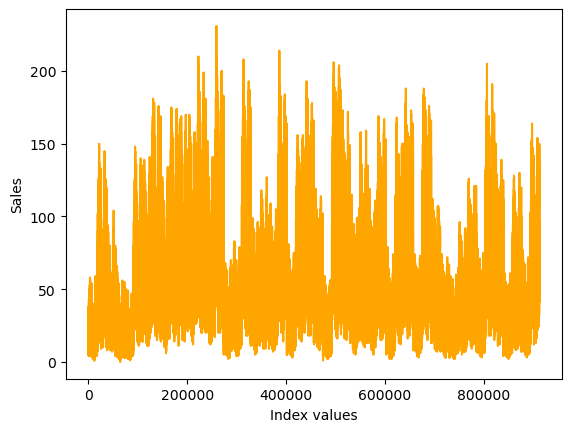

In [8]:
df_s['sales'].plot(color="orange")
plt.xlabel('Index values')  # Replace with your desired label
plt.ylabel('Sales')          # Replace with your desired label

# Display the plot
plt.show()

In [9]:
df_s.head()

date  store  item  sales
0  01-01-2013      1     1     13
1  02-01-2013      1     1     11
2  03-01-2013      1     1     14
3  04-01-2013      1     1     13
4  05-01-2013      1     1     10

In [10]:
df_s.shape

(913000, 4)

In [11]:
913000*4

3652000

In [12]:
df_s['sales'].max()

231

In [13]:
def monthlyORyears_sales(data,time=['monthly','years']):
    data = data.copy()
    if time == "monthly":
        # Drop the day indicator from the date column:
        data.date = data.date.apply(lambda x: str(x)[:-3])
    else:
        data.date = data.date.apply(lambda x: str(x)[:4])
        
   # Sum sales per month: 
    data = data.groupby('date')['sales'].sum().reset_index()
    data.date = pd.to_datetime(data.date)
        
    return data
    

In [14]:
import pandas as pd

def monthlyORyears_sales(data, time='monthly'):
    data = data.copy()
    
    # Ensure the date column is a string
    data['date'] = data['date'].astype(str)
    
    # Handle the invalid date entries by checking the length of the year part
    def fix_date(date_str):
        parts = date_str.split('-')
        if len(parts) == 3:
            day, month, year = parts
            if len(year) == 1:  # Add '20' to years like '2'
                year = '200' + year
            elif len(year) == 2:  # Assuming '02' is '2002'
                year = '20' + year
            elif len(year) == 4:
                year = year
            else:
                return None  # Invalid year length
            return f"{day}-{month}-{year}"
        return None  # Invalid date format

    # Fix dates in the DataFrame
    data['date'] = data['date'].apply(fix_date)

    # Drop rows with invalid dates
    data = data[data['date'].notnull()]

    # Convert to datetime
    data['date'] = pd.to_datetime(data['date'], format='%d-%m-%Y', errors='coerce')

    # Drop rows with NaT in the date column after conversion
    data = data[data['date'].notna()]

    # Create monthly/yearly data
    if time == "monthly":
        # Drop the day indicator from the date column
        data['date'] = data['date'].dt.to_period('M').astype(str)
    else:  # Assuming 'years'
        data['date'] = data['date'].dt.to_period('Y').astype(str)

    # Sum sales per month/year
    data = data.groupby('date')['sales'].sum().reset_index()

    return data


In [15]:
print(df_s[df_s["date"]=="29-02-2"])

Empty DataFrame
Columns: [date, store, item, sales]
Index: []


In [16]:
filtered_df = df_s[df_s['date'] == '29-02-2']

print(filtered_df)

Empty DataFrame
Columns: [date, store, item, sales]
Index: []


In [17]:
df.iloc[337]

id       337
sales     52
Name: 337, dtype: int64

In [18]:
df_s.iloc[337]

date     04-12-2013
store             1
item              1
sales             6
Name: 337, dtype: object

In [19]:
m_df = monthlyORyears_sales(df_s,"monthly")

In [20]:
m_df.head(10)

date   sales
0  2013-01  454904
1  2013-02  459417
2  2013-03  617382
3  2013-04  682274
4  2013-05  763242
5  2013-06  795597
6  2013-07  855922
7  2013-08  766761
8  2013-09  689907
9  2013-10  656587

In [21]:
y_df=monthlyORyears_sales(df_s,"years")

In [22]:
y_df.head()

date     sales
0  2013   7941243
1  2014   9135482
2  2015   9536887
3  2016  10357160
4  2017  10733740

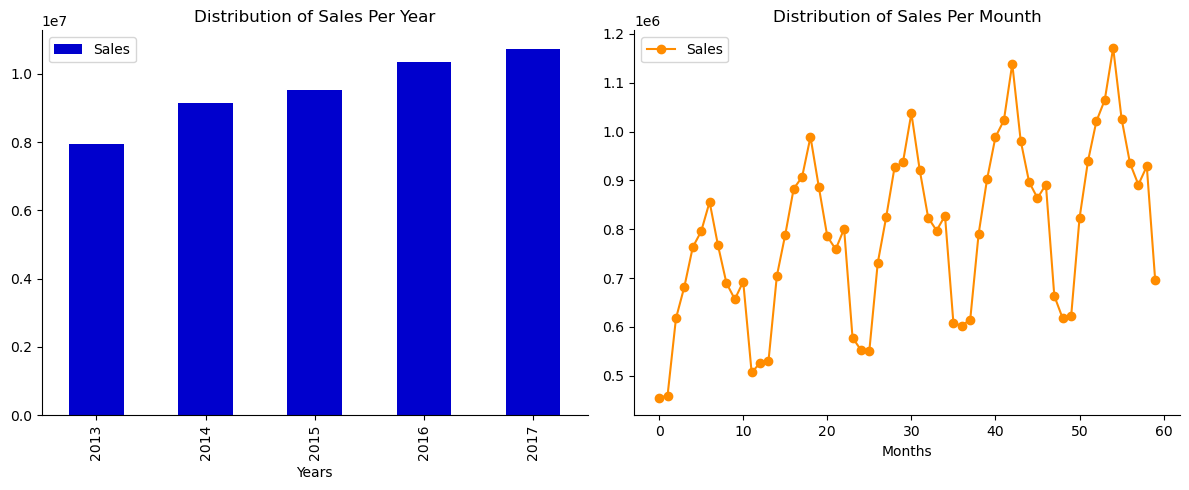

In [23]:
layout = (1, 2)

raw = plt.subplot2grid(layout, (0 ,0))
law = plt.subplot2grid(layout, (0 ,1))

years = y_df.plot(kind="bar", x='date', y='sales', color='mediumblue', label="Sales", ax=raw, figsize=(12, 5))

months = m_df['sales'].plot(marker = 'o',color = 'darkorange', label="Sales", ax=law)

years.set(xlabel = "Years",title = "Distribution of Sales Per Year")
months.set(xlabel = "Months", title = "Distribution of Sales Per Mounth")

sns.despine()
plt.tight_layout()

years.legend()
months.legend()

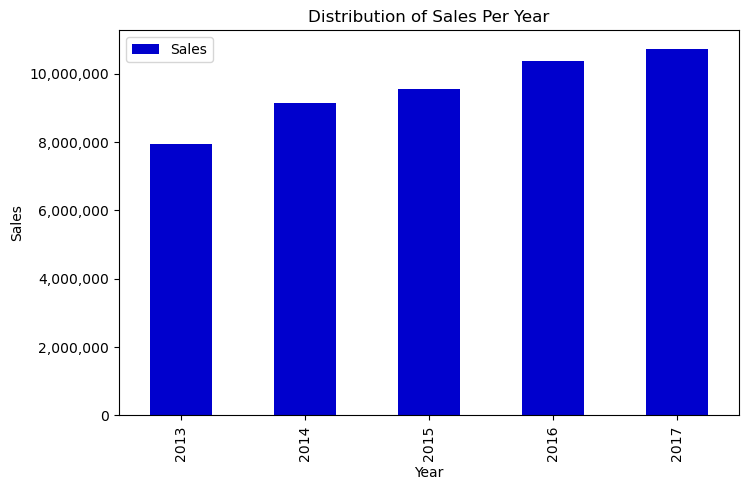

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming `y_df` is your DataFrame with 'date' and 'sales' columns

# Create the figure and subplot
fig, raw = plt.subplots(figsize=(8, 5))

# Plot the bar chart
years = y_df.plot(kind="bar", x='date', y='sales', color='mediumblue', label="Sales", ax=raw)

# Set the title and labels
raw.set_title("Distribution of Sales Per Year")
raw.set_xlabel("Year")
raw.set_ylabel("Sales")

# Format the y-axis to show original values
raw.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Show the plot
plt.show()


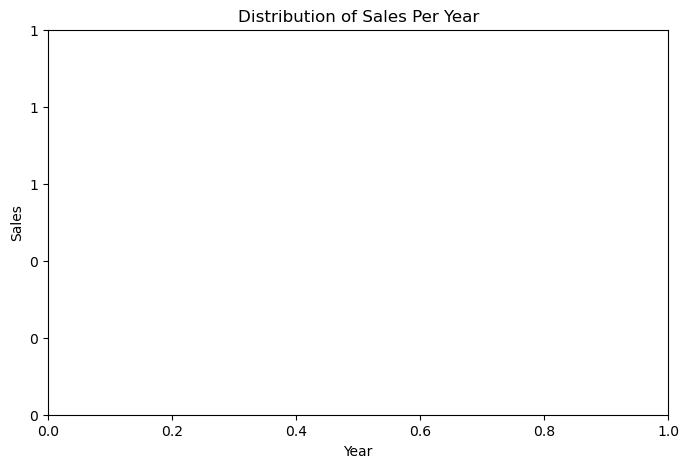

In [25]:
fig, raw = plt.subplots(figsize=(8, 5))

# Plot the bar chart
months = m_df['sales'].plot(marker = 'o',color = 'darkorange', label="Sales", ax=law)

# Set the title and labels
raw.set_title("Distribution of Sales Per Year")
raw.set_xlabel("Year")
raw.set_ylabel("Sales")

# Format the y-axis to show original values
raw.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Show the plot
plt.show()

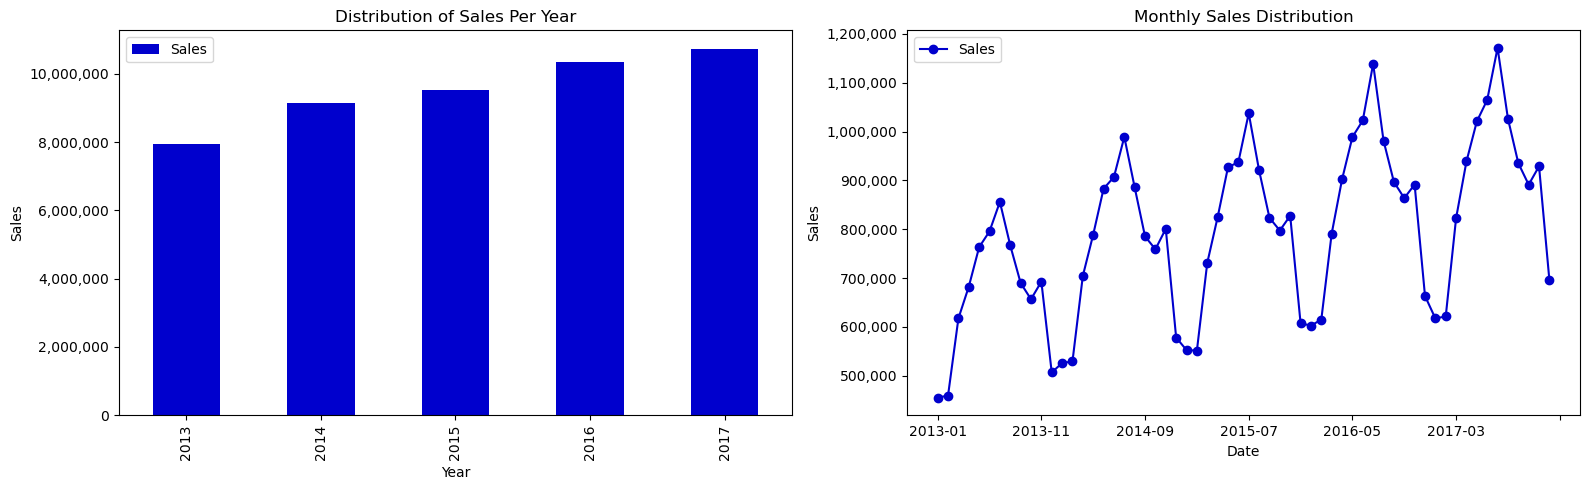

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming `m_df` is your DataFrame with 'date' and 'sales' columns

# Create the figure and subplots
fig, (raw, law) = plt.subplots(1, 2, figsize=(16, 5))

# Plot the bar chart on the 'raw' subplot
years = y_df.plot(kind="bar", x='date', y='sales', color='mediumblue', label="Sales", ax=raw)

# Plot the line chart on the 'law' subplot
months = m_df.plot(marker='o', x='date', y='sales', color='mediumblue', label="Sales", ax=law)

# Set the title and labels for the 'raw' subplot
raw.set_title("Distribution of Sales Per Year")
raw.set_xlabel("Year")
raw.set_ylabel("Sales")

# Format the y-axis to show original values for the 'raw' subplot
raw.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Set the title and labels for the 'law' subplot
law.set_title("Monthly Sales Distribution")
law.set_xlabel("Date")
law.set_ylabel("Sales")

# Format the y-axis to show original values for the 'law' subplot
law.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Show the plot
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd

def sales_time(data):
    """Time interval of dataset:"""

    # Convert the date column to datetime, specifying the correct format
    data.date = pd.to_datetime(data.date, format='%d-%m-%Y', errors='coerce')  # Adjusted format

    # Check for any NaT values in the date column (this indicates a problem with conversion)
    if data.date.isnull().any():
        print("Warning: Some dates could not be converted and will be set to NaT.")

    n_of_days = data.date.max() - data.date.min()
    n_of_years = int(n_of_days.days / 365)
    
    print(f"Days: {n_of_days.days}\nYears: {n_of_years}\nMonths: {12 * n_of_years}")

# Example of how to call the function with your DataFrame
# sales_time(df_s)


In [28]:
sales_time(df_s)

Days: 1825
Years: 5
Months: 60


In [29]:
df_s

date  store  item  sales
0      2013-01-01      1     1     13
1      2013-01-02      1     1     11
2      2013-01-03      1     1     14
3      2013-01-04      1     1     13
4      2013-01-05      1     1     10
...           ...    ...   ...    ...
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82

[913000 rows x 4 columns]

In [30]:
'''The main role of the `sales_time` function is to analyze the time interval of a dataset, specifically focusing on the dates in the provided DataFrame. Here’s a breakdown of its primary functions:

1. **Date Conversion**: 
   - It converts the date strings in the `date` column of the DataFrame into a datetime format using `pd.to_datetime()`. This allows for better manipulation and analysis of the dates.

2. **Interval Calculation**:
   - The function calculates the total number of days between the maximum and minimum dates in the dataset. This provides an understanding of the time span covered by the data.

3. **Year Calculation**:
   - It converts the total number of days into years, giving a more intuitive understanding of the duration.

4. **Output**: 
   - Finally, it prints the number of days, years, and an approximate number of months covered in the dataset, helping users quickly understand the time coverage of their data.

Overall, this function is useful for anyone needing to understand the temporal aspect of their dataset, especially in contexts like time series analysis, sales forecasting, or trend analysis.'''

'The main role of the `sales_time` function is to analyze the time interval of a dataset, specifically focusing on the dates in the provided DataFrame. Here’s a breakdown of its primary functions:\n\n1. **Date Conversion**: \n   - It converts the date strings in the `date` column of the DataFrame into a datetime format using `pd.to_datetime()`. This allows for better manipulation and analysis of the dates.\n\n2. **Interval Calculation**:\n   - The function calculates the total number of days between the maximum and minimum dates in the dataset. This provides an understanding of the time span covered by the data.\n\n3. **Year Calculation**:\n   - It converts the total number of days into years, giving a more intuitive understanding of the duration.\n\n4. **Output**: \n   - Finally, it prints the number of days, years, and an approximate number of months covered in the dataset, helping users quickly understand the time coverage of their data.\n\nOverall, this function is useful for anyon

In [31]:
# sales data per srore
def sales_per_store(data):
    sales_by_store=data.groupby("store")["sales"].sum().reset_index()
    fig,ax=plt.subplots(figsize=(8,6))
    sns.barplot(x=sales_by_store.store,y=sales_by_store.sales,color='darkred')
    ax.set(xlabel="Store_ID",ylabel="Sum_of_Sales",title="Total_sales_Per_Store")
    return sales_by_store



store    sales
0      1  4315603
1      2  6120128
2      3  5435144
3      4  5012639
4      5  3631016
5      6  3627670
6      7  3320009
7      8  5856169
8      9  5025976
9     10  5360158

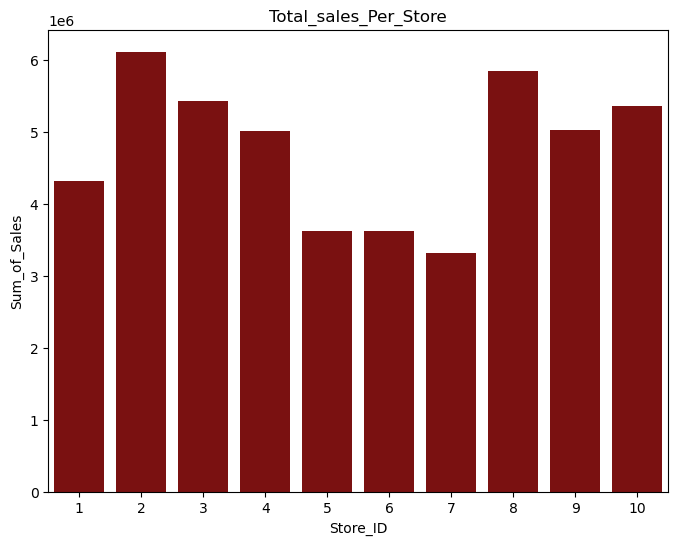

In [32]:
sales_per_store(df_s)

In [33]:
average_m_sales=m_df.sales.mean()
print(f"Overall monthly average sales: ${average_m_sales}")

def avarage_12months():
    #Last one year will be forecasted
    average_m_sales_1y= m_df.sales[-12:].mean()
    print(f"Last 12 months average monthly sales: ${average_m_sales_1y}")
avarage_12months()

Overall monthly average sales: $795075.2
Last 12 months average monthly sales: $894478.3333333334


In [34]:
def time_plot(data,x_col,y_col):
    fig,ax=plt.subplots(figsize=(8,5))
    sns.lineplot(x=x_col,y=y_col, data=data, ax=ax, color="darkblue", label="Total Sales")

    s_mean=data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    s_mean.date = pd.to_datetime(s_mean.date,format="%Y")
    sns.lineplot((s_mean.date + datetime.timedelta(6*365/12)), y_col, data=s_mean, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Years",
           ylabel = "Sales",
           title = title)

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def time_plot(data, x_col, y_col):
    # Ensure the date column is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(data[x_col]):
        data[x_col] = pd.to_datetime(data[x_col])

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.lineplot(x=x_col, y=y_col, data=data, ax=ax, color="darkblue", label="Total Sales")

    # Calculate the mean sales per year
    s_mean = data.groupby(data[x_col].dt.year)[y_col].mean().reset_index()
    s_mean.columns = ['year', y_col]  # Rename columns for clarity
    s_mean['year'] = pd.to_datetime(s_mean['year'], format="%Y")

    # Plot the mean sales
    sns.lineplot(x=s_mean['year'] + pd.DateOffset(months=6), y=s_mean[y_col], ax=ax, color='red', label='Mean Sales')   

    # Set labels and title
    ax.set(xlabel="Years", ylabel="Sales", title="Total Sales and Mean Sales Over Time")
    
    plt.legend()
    plt.show()



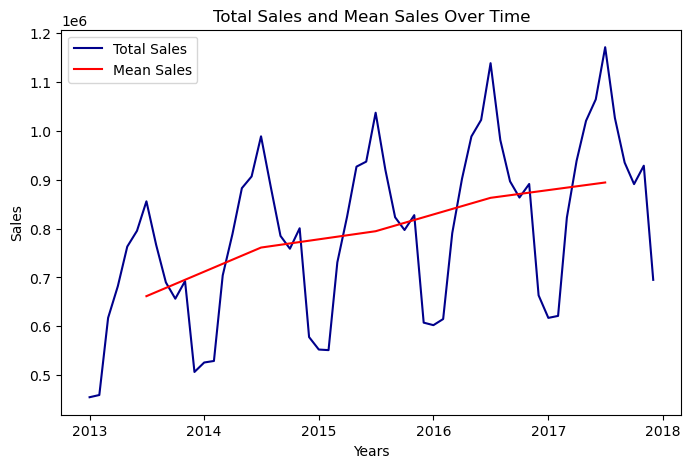

In [36]:
time_plot(m_df, 'date', 'sales')

In [37]:
#Ho: It is non stationary
#H1: It is stationary

from statsmodels.tsa.stattools import adfuller

def adfuller_test(series):
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary.")



In [38]:
adfuller_test(m_df['sales'])

ADF Test Statistic: -5.247518850016357
p-value: 7.026495391574532e-06
# Lags Used: 11
Number of Observations Used: 48
Strong evidence against the null hypothesis (Ho), reject the null hypothesis. Data has no unit root and is stationary.


In [39]:
def get_diff(data):
    """Calculate the difference in sales month over month:"""
    
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('./stationary_df.csv')
    
    return data


In [40]:
stationary_df = get_diff(m_df)

In [41]:
adfuller_test(stationary_df['sales_diff'])

ADF Test Statistic: -1.5289959815021652
p-value: 0.5191218072432624
# Lags Used: 11
Number of Observations Used: 47
Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary.


In [42]:
stationary_df.columns

Index(['date', 'sales', 'sales_diff'], dtype='object')

In [43]:
result = adfuller(stationary_df['sales_diff'])
print(result)

(-1.5289959815021652, 0.5191218072432624, 11, 47, {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 1054.121009408024)


In [44]:
def create_date_features(df):
    df["month"] = df.date.dt.month
    df["day_of_month"] = df.date.dt.day
    df["day_of_year"] = df.date.dt.dayofyear
    df["week_of_year"] = df.date.dt.isocalendar().week
    df["day_of_week"] = df.date.dt.dayofweek
    df["year"] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df["is_month_start"] = df.date.dt.is_month_start.astype(int)
    df["is_month_end"] = df.date.dt.is_month_end.astype(int)
    return df

create_date_features(df_s)

date  store  item  sales  month  day_of_month  day_of_year  \
0      2013-01-01      1     1     13      1             1            1   
1      2013-01-02      1     1     11      1             2            2   
2      2013-01-03      1     1     14      1             3            3   
3      2013-01-04      1     1     13      1             4            4   
4      2013-01-05      1     1     10      1             5            5   
...           ...    ...   ...    ...    ...           ...          ...   
912995 2017-12-27     10    50     63     12            27          361   
912996 2017-12-28     10    50     59     12            28          362   
912997 2017-12-29     10    50     74     12            29          363   
912998 2017-12-30     10    50     62     12            30          364   
912999 2017-12-31     10    50     82     12            31          365   

        week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  
0                  1            1  2013        0               1             0  
1                  1            2  2013        0               0             0  
2                  1            3  2013        0               0             0  
3                  1            4  2013        1               0             0  
4                  1            5  2013        1               0             0  
...              ...          ...   ...      ...             ...           ...  
912995            52            2  2017        0               0             0  
912996            52            3  2017        0               0             0  
912997            52            4  2017        1               0             0  
912998            52            5  2017        1               0             0  
912999            52            6  2017        1               0             1  

[913000 rows x 13 columns]

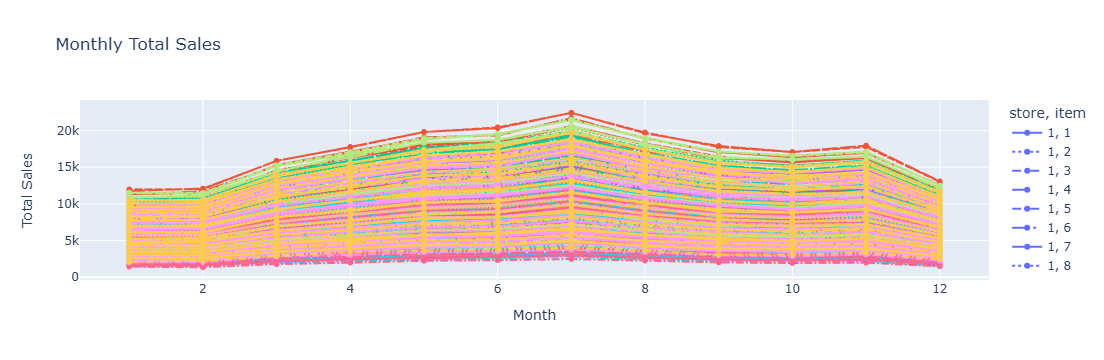

In [45]:
import plotly.express as px
agg_df = df_s.groupby(['store', 'item', 'month']).agg({'sales': 'sum'}).reset_index()

fig = px.line(agg_df, x='month', y='sales', color='store', line_dash='item',
              title='Monthly Total Sales',
              labels={'sales': 'Total Sales', 'month': 'Month'},
              markers=True)
fig.update_layout(xaxis_title='Month', yaxis_title='Total Sales')
fig.show()


In [46]:
def get_diff(data):
    data["sales_diff"]=data.sales.diff()
    data=data.dropna()
    return data

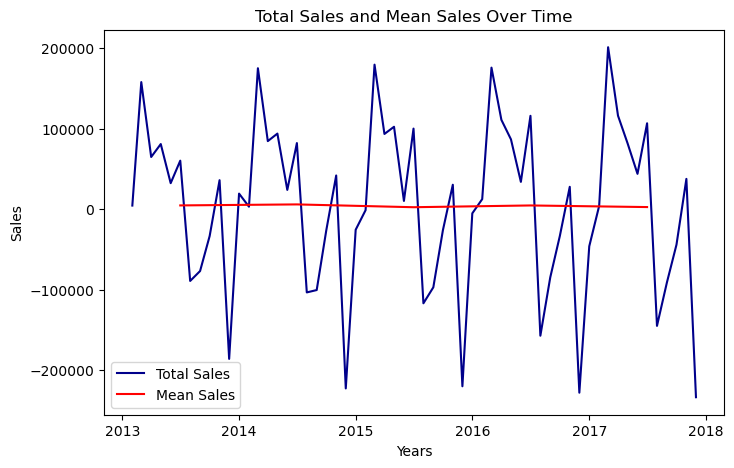

In [47]:
stationary_df=get_diff(m_df)
time_plot(stationary_df, 'date', 'sales_diff')

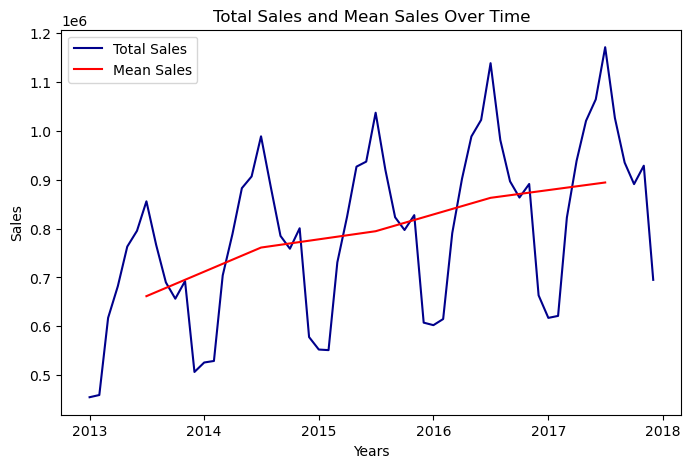

In [48]:
time_plot(m_df, 'date', 'sales')

In [49]:
def build_arima_data(data):
    """Generates a csv-file with a datetime index and a dependent sales column for ARIMA modeling."""
    
    da_data = data.set_index('date').drop('sales', axis=1)
    da_data.dropna(axis=0)
    
    #da_data.to_csv('./arima_df.csv')
    
    return da_data

In [50]:
datatime_df = build_arima_data(stationary_df)
datatime_df # ARIMA Dataframe

sales_diff
date                  
2013-02-01      4513.0
2013-03-01    157965.0
2013-04-01     64892.0
2013-05-01     80968.0
2013-06-01     32355.0
2013-07-01     60325.0
2013-08-01    -89161.0
2013-09-01    -76854.0
2013-10-01    -33320.0
2013-11-01     36056.0
2013-12-01   -186036.0
2014-01-01     19380.0
2014-02-01      3130.0
2014-03-01    175184.0
2014-04-01     84613.0
2014-05-01     93963.0
2014-06-01     23965.0
2014-07-01     82168.0
2014-08-01   -103414.0
2014-09-01   -100472.0
2014-10-01    -26241.0
2014-11-01     41900.0
2014-12-01   -222735.0
2015-01-01    -25535.0
2015-02-01     -1196.0
2015-03-01    179634.0
2015-04-01     93516.0
2015-05-01    102435.0
2015-06-01     10282.0
2015-07-01    100166.0
2015-08-01   -116949.0
2015-09-01    -97069.0
2015-10-01    -26079.0
2015-11-01     30392.0
2015-12-01   -220073.0
2016-01-01     -5133.0
2016-02-01     12518.0
2016-03-01    175924.0
2016-04-01    111069.0
2016-05-01     86780.0
2016-06-01     33934.0
2016-07-01    116054.0
2016-08-01   -157224.0
2016-09-01    -84663.0
2016-10-01    -33194.0
2016-11-01     27811.0
2016-12-01   -228037.0
2017-01-01    -46105.0
2017-02-01      4063.0
2017-03-01    201298.0
2017-04-01    116195.0
2017-05-01     81824.0
2017-06-01     43938.0
2017-07-01    106769.0
2017-08-01   -144990.0
2017-09-01    -91140.0
2017-10-01    -44103.0
2017-11-01     37677.0
2017-12-01   -233667.0

In [51]:
def built_supervised(data):
    supervised_df = data.copy()

    # Create column for each lag:
    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    # Drop null values:
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    #supervised_df.to_csv('./model_df.csv', index=False)
    
    return supervised_df

In [52]:
model_df = built_supervised(stationary_df)
model_df 

date    sales  sales_diff     lag_1     lag_2     lag_3     lag_4  \
0  2014-02-01   529117      3130.0   19380.0 -186036.0   36056.0  -33320.0   
1  2014-03-01   704301    175184.0    3130.0   19380.0 -186036.0   36056.0   
2  2014-04-01   788914     84613.0  175184.0    3130.0   19380.0 -186036.0   
3  2014-05-01   882877     93963.0   84613.0  175184.0    3130.0   19380.0   
4  2014-06-01   906842     23965.0   93963.0   84613.0  175184.0    3130.0   
5  2014-07-01   989010     82168.0   23965.0   93963.0   84613.0  175184.0   
6  2014-08-01   885596   -103414.0   82168.0   23965.0   93963.0   84613.0   
7  2014-09-01   785124   -100472.0 -103414.0   82168.0   23965.0   93963.0   
8  2014-10-01   758883    -26241.0 -100472.0 -103414.0   82168.0   23965.0   
9  2014-11-01   800783     41900.0  -26241.0 -100472.0 -103414.0   82168.0   
10 2014-12-01   578048   -222735.0   41900.0  -26241.0 -100472.0 -103414.0   
11 2015-01-01   552513    -25535.0 -222735.0   41900.0  -26241.0 -100472.0   
12 2015-02-01   551317     -1196.0  -25535.0 -222735.0   41900.0  -26241.0   
13 2015-03-01   730951    179634.0   -1196.0  -25535.0 -222735.0   41900.0   
14 2015-04-01   824467     93516.0  179634.0   -1196.0  -25535.0 -222735.0   
15 2015-05-01   926902    102435.0   93516.0  179634.0   -1196.0  -25535.0   
16 2015-06-01   937184     10282.0  102435.0   93516.0  179634.0   -1196.0   
17 2015-07-01  1037350    100166.0   10282.0  102435.0   93516.0  179634.0   
18 2015-08-01   920401   -116949.0  100166.0   10282.0  102435.0   93516.0   
19 2015-09-01   823332    -97069.0 -116949.0  100166.0   10282.0  102435.0   
20 2015-10-01   797253    -26079.0  -97069.0 -116949.0  100166.0   10282.0   
21 2015-11-01   827645     30392.0  -26079.0  -97069.0 -116949.0  100166.0   
22 2015-12-01   607572   -220073.0   30392.0  -26079.0  -97069.0 -116949.0   
23 2016-01-01   602439     -5133.0 -220073.0   30392.0  -26079.0  -97069.0   
24 2016-02-01   614957     12518.0   -5133.0 -220073.0   30392.0  -26079.0   
25 2016-03-01   790881    175924.0   12518.0   -5133.0 -220073.0   30392.0   
26 2016-04-01   901950    111069.0  175924.0   12518.0   -5133.0 -220073.0   
27 2016-05-01   988730     86780.0  111069.0  175924.0   12518.0   -5133.0   
28 2016-06-01  1022664     33934.0   86780.0  111069.0  175924.0   12518.0   
29 2016-07-01  1138718    116054.0   33934.0   86780.0  111069.0  175924.0   
30 2016-08-01   981494   -157224.0  116054.0   33934.0   86780.0  111069.0   
31 2016-09-01   896831    -84663.0 -157224.0  116054.0   33934.0   86780.0   
32 2016-10-01   863637    -33194.0  -84663.0 -157224.0  116054.0   33934.0   
33 2016-11-01   891448     27811.0  -33194.0  -84663.0 -157224.0  116054.0   
34 2016-12-01   663411   -228037.0   27811.0  -33194.0  -84663.0 -157224.0   
35 2017-01-01   617306    -46105.0 -228037.0   27811.0  -33194.0  -84663.0   
36 2017-02-01   621369      4063.0  -46105.0 -228037.0   27811.0  -33194.0   
37 2017-03-01   822667    201298.0    4063.0  -46105.0 -228037.0   27811.0   
38 2017-04-01   938862    116195.0  201298.0    4063.0  -46105.0 -228037.0   
39 2017-05-01  1020686     81824.0  116195.0  201298.0    4063.0  -46105.0   
40 2017-06-01  1064624     43938.0   81824.0  116195.0  201298.0    4063.0   
41 2017-07-01  1171393    106769.0   43938.0   81824.0  116195.0  201298.0   
42 2017-08-01  1026403   -144990.0  106769.0   43938.0   81824.0  116195.0   
43 2017-09-01   935263    -91140.0 -144990.0  106769.0   43938.0   81824.0   
44 2017-10-01   891160    -44103.0  -91140.0 -144990.0  106769.0   43938.0   
45 2017-11-01   928837     37677.0  -44103.0  -91140.0 -144990.0  106769.0   
46 2017-12-01   695170   -233667.0   37677.0  -44103.0  -91140.0 -144990.0   

       lag_5     lag_6     lag_7     lag_8     lag_9    lag_10    lag_11  \
0   -76854.0  -89161.0   60325.0   32355.0   80968.0   64892.0  157965.0   
1   -33320.0  -76854.0  -89161.0   60325.0   32355.0   80968.0   64892.0   
2    36056.0  -33320.0  -76854.0  -8

In [53]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        47 non-null     datetime64[ns]
 1   sales       47 non-null     int64         
 2   sales_diff  47 non-null     float64       
 3   lag_1       47 non-null     float64       
 4   lag_2       47 non-null     float64       
 5   lag_3       47 non-null     float64       
 6   lag_4       47 non-null     float64       
 7   lag_5       47 non-null     float64       
 8   lag_6       47 non-null     float64       
 9   lag_7       47 non-null     float64       
 10  lag_8       47 non-null     float64       
 11  lag_9       47 non-null     float64       
 12  lag_10      47 non-null     float64       
 13  lag_11      47 non-null     float64       
 14  lag_12      47 non-null     float64       
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 5.6 KB


In [54]:
def train_test_split(data):
    print(data)
    data=data.drop(['sales','date'],axis=1)
    print(data)
    train,test=data[:12].values,data[-12:].values
    return train,test
train, test = train_test_split(model_df)
print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}")

         date    sales  sales_diff     lag_1     lag_2     lag_3     lag_4  \
0  2014-02-01   529117      3130.0   19380.0 -186036.0   36056.0  -33320.0   
1  2014-03-01   704301    175184.0    3130.0   19380.0 -186036.0   36056.0   
2  2014-04-01   788914     84613.0  175184.0    3130.0   19380.0 -186036.0   
3  2014-05-01   882877     93963.0   84613.0  175184.0    3130.0   19380.0   
4  2014-06-01   906842     23965.0   93963.0   84613.0  175184.0    3130.0   
5  2014-07-01   989010     82168.0   23965.0   93963.0   84613.0  175184.0   
6  2014-08-01   885596   -103414.0   82168.0   23965.0   93963.0   84613.0   
7  2014-09-01   785124   -100472.0 -103414.0   82168.0   23965.0   93963.0   
8  2014-10-01   758883    -26241.0 -100472.0 -103414.0   82168.0   23965.0   
9  2014-11-01   800783     41900.0  -26241.0 -100472.0 -103414.0   82168.0   
10 2014-12-01   578048   -222735.0   41900.0  -26241.0 -100472.0 -103414.0   
11 2015-01-01   552513    -25535.0 -222735.0   41900.0  -26241.0

In [55]:
def scale_data(train_set,test_set):
    """Scales data using MinMaxScaler and separates data into X_train, y_train,
    X_test, and y_test."""
    
    # Apply Min Max Scaler:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # Reshape training set:
    train_set = train_set.reshape(train_set.shape[0],
                                  train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # Reshape test set:
    test_set = test_set.reshape(test_set.shape[0], 
                                test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    ,
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel() # returns the array, flattened!
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler


X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}")

Shape of X Train: (12, 12)
Shape of y Train: (12,)
Shape of X Test: (12, 12)
Shape of y Test: (12,)


In [56]:
y_train

array([ 0.13523104,  1.        ,  0.5447767 ,  0.59177119,  0.23995084,
        0.53248777, -0.40027493, -0.385488  , -0.01239197,  0.33009482,
       -1.        , -0.00884351])

In [57]:
X_train

array([[ 0.21690595, -1.        ,  0.22967721, -0.15444328, -0.39548198,
        -0.46362328,  0.36404961,  0.20918554,  0.47834561,  0.38933614,
         1.        ,  0.1078398 ],
       [ 0.13523104,  0.13734566, -1.        ,  0.22967721, -0.15444328,
        -0.39548198, -0.46362328,  0.36404961,  0.20918554,  0.47834561,
         0.45887948,  1.        ],
       [ 1.        ,  0.04737279,  0.13734566, -1.        ,  0.22967721,
        -0.15444328, -0.39548198, -0.46362328,  0.36404961,  0.20918554,
         0.55234432,  0.45887948],
       [ 0.5447767 ,  1.        ,  0.04737279,  0.13734566, -1.        ,
         0.22967721, -0.15444328, -0.39548198, -0.46362328,  0.36404961,
         0.26971143,  0.55234432],
       [ 0.59177119,  0.49852721,  1.        ,  0.04737279,  0.13734566,
        -1.        ,  0.22967721, -0.15444328, -0.39548198, -0.46362328,
         0.43232723,  0.26971143],
       [ 0.23995084,  0.55029622,  0.49852721,  1.        ,  0.04737279,
         0.13734566, -

 Reverse Scaling
>       After running our models, we will use this helper function to reverse the scaling of step 2.

In [58]:
def re_scaling(y_pred, x_test, scaler_obj, lstm=False):
    """For visualizing and comparing results, undoes the scaling effect on predictions."""
   # y_pred: model predictions
   # x_test: features from the test set used for predictions
   # scaler_obj: the scaler objects used for min-max scaling
   # lstm: indicate if the model run is the lstm. If True, additional transformation occurs 
    
    # Reshape y_pred:
    y_pred = y_pred.reshape(y_pred.shape[0],
                            1,
                            1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0],
                                1, 
                                x_test.shape[1])

    # Rebuild test set for inverse transform:
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], 
                                             x_test[index]],
                                             axis=1) )

    # Reshape pred_test_set:
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])

    # Inverse transform:
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted
    

 # Predictions Dataframe
>     Generate a dataframe that includes the actual sales captured in our test set and the predicted results from our model so that we can quantify our success.

In [59]:
def prediction_df(unscale_predictions, origin_df):
    """Generates a dataframe that shows the predicted sales for each month
    for plotting results."""
    
    # unscale_predictions: the model predictions that do not have min-max or other scaling applied
    # origin_df: the original monthly sales dataframe
    
    # Create dataframe that shows the predicted sales:
    result_list = []
    sales_dates = list(origin_df[-13:].date)
    act_sales = list(origin_df[-13:].sales)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index + 1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

In [60]:
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison."""
    
    rmse = np.sqrt(mean_squared_error(origin_df.sales[-12:], 
                                      unscale_df.pred_value[-12:]))
    
    mae = mean_absolute_error(origin_df.sales[-12:], 
                              unscale_df.pred_value[-12:])
    
    r2 = r2_score(origin_df.sales[-12:], 
                  unscale_df.pred_value[-12:])
    
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model as percentages. Saves all results in a model_scores dictionary for
    comparison."""
    
    rmse = np.sqrt(mean_squared_error(origin_df.sales[-12:], unscale_df.pred_value[-12:]))
    mae = mean_absolute_error(origin_df.sales[-12:], unscale_df.pred_value[-12:])
    r2 = r2_score(origin_df.sales[-12:], unscale_df.pred_value[-12:])
    
    # Calculate percaentages
    rmse_percentage = (rmse / np.mean(origin_df.sales[-12:])) * 100
    mae_percentage = (mae / np.mean(origin_df.sales[-12:])) * 100
    
    model_scores[model_name] = [rmse_percentage, mae_percentage, r2 * 100]
    
    print(f"RMSE: {rmse_percentage:.2f}%\nMAE: {mae_percentage:.2f}%\nR2 Score: {r2 * 100:.2f}%")

# Example usage
# get_scores(unscale_df, origin_df, 'model_name')


In [61]:
def plot_results(results,origin_df,model_name):
    # results: a dataframe with unscaled predictions
    fig,ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=origin_df.date,y=origin_df.sales,data=origin_df,ax=ax,label="Original",color='blue')
    sns.lineplot(x=results.date,y=results.pred_value,data=results,ax=ax,label="Predicted",color="Red")
    ax.set(xlabel = "Date", ylabel = "Sales", title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend(loc='best')


In [62]:
def regressive_model(train_data, test_data, model, model_name):
    """Runs regressive models in SKlearn framework. First calls scale_data
    to split into X and y and scale the data. Then fits and predicts. Finally,
    predictions are unscaled, scores are printed, and results are plotted and
    saved."""
    
    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data,
                                                                 test_data)

    # Run sklearn models:
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test) # y_pred=predictions

    # Undo scaling to compare predictions against original data:
    origin_df = m_df
    unscaled = re_scaling(predictions, X_test, scaler_object) # unscaled_predictions
    unscaled_df = prediction_df(unscaled, origin_df)

    # Print scores and plot results:
    get_scores(unscaled_df, origin_df, model_name)
    plot_results(unscaled_df, origin_df, model_name)

RMSE: 23531.20170291635
MAE: 18886.416666666668
R2 Score: 0.9804617714359699


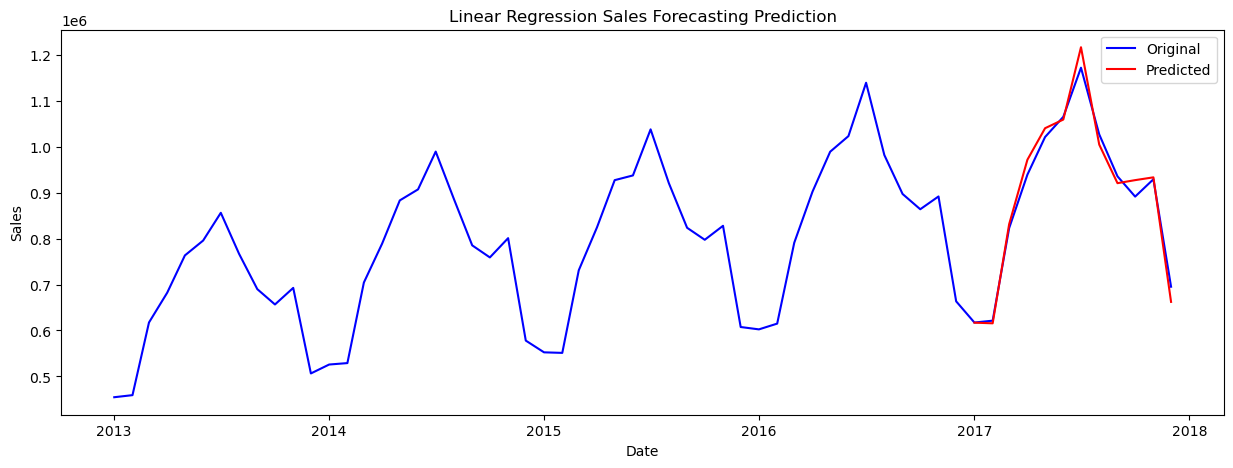

In [63]:
regressive_model(train,test,LinearRegression(),"Linear Regression")

RMSE: 37651.910449537616
MAE: 26421.166666666668
R2 Score: 0.949976853357726


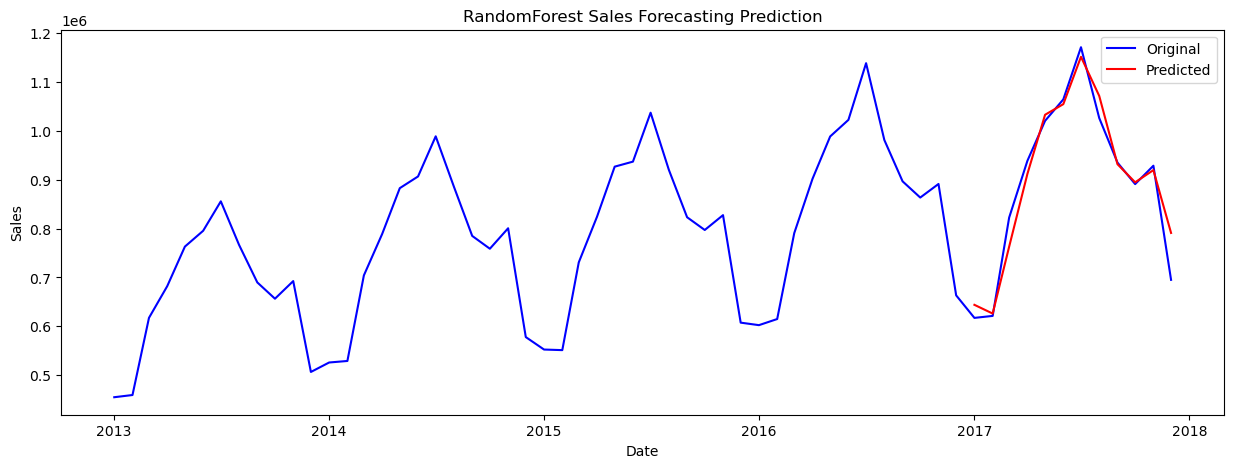

In [64]:
regressive_model(train,test,RandomForestRegressor(n_estimators=100,max_depth=20),"RandomForest")

RMSE: 24030.60388858341
MAE: 20920.75
R2 Score: 0.9796236523225046


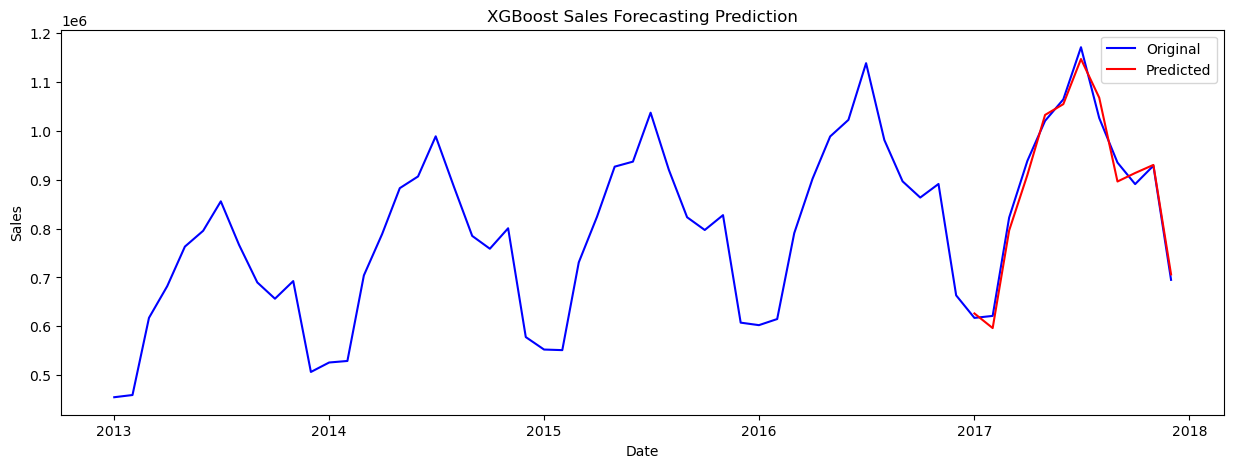

In [65]:
regressive_model(train, test, XGBRegressor(n_estimators=100,max_depth=3, 
                                           learning_rate=0.2,objective='reg:squarederror'), 'XGBoost')

In [66]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def sarimax_model(data):
    # Fit the SARIMAX model
    sar = sm.tsa.statespace.SARIMAX(data.sales_diff, order=(12, 0, 0),
                                    seasonal_order=(0, 1, 0, 12),
                                    trend='c').fit()
    
    # Generate predictions
    start, end, dynamic = 40, 100, 7
    data['pred_value'] = sar.predict(start=start, end=end, dynamic=dynamic)
    pred_df = data.pred_value[start + dynamic:end]
    
    # Plot the actual and predicted values
    data[["sales_diff", "pred_value"]].plot(color=['blue', 'red'])
    plt.legend(loc='upper left')
    
    # Calculate model scores
    model_scores = {}
    
    # Calculate RMSE, MAE, and R²
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.pred_value[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.pred_value[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.pred_value[-12:])
    
    # Calculate mean of the actual values for percentage calculation
    mean_actual = np.mean(data.sales_diff[-12:])
    
    # Calculate percentages
    rmse_percentage = (rmse / mean_actual) * 100
    mae_percentage = (mae / mean_actual) * 100
    r2_percentage = r2 * 100  # R² is already a ratio, multiplying by 100 gives percentage

    # Store the model scores
    model_scores['ARIMA'] = [rmse_percentage, mae_percentage, r2_percentage]
    
    # Print scores
    print(f"RMSE (%): {rmse_percentage:.2f}%")
    print(f"MAE (%): {mae_percentage:.2f}%")
    print(f"R² Score (%): {r2_percentage:.2f}%")
    
    return sar, data, pred_df


C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



RMSE (%): 565.25%
MAE (%): 425.66%
R² Score (%): 98.36%


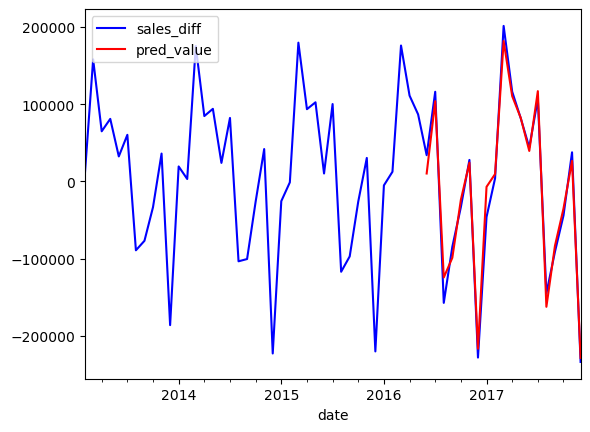

In [67]:
sar, datatime_df, predictions = sarimax_model(datatime_df)

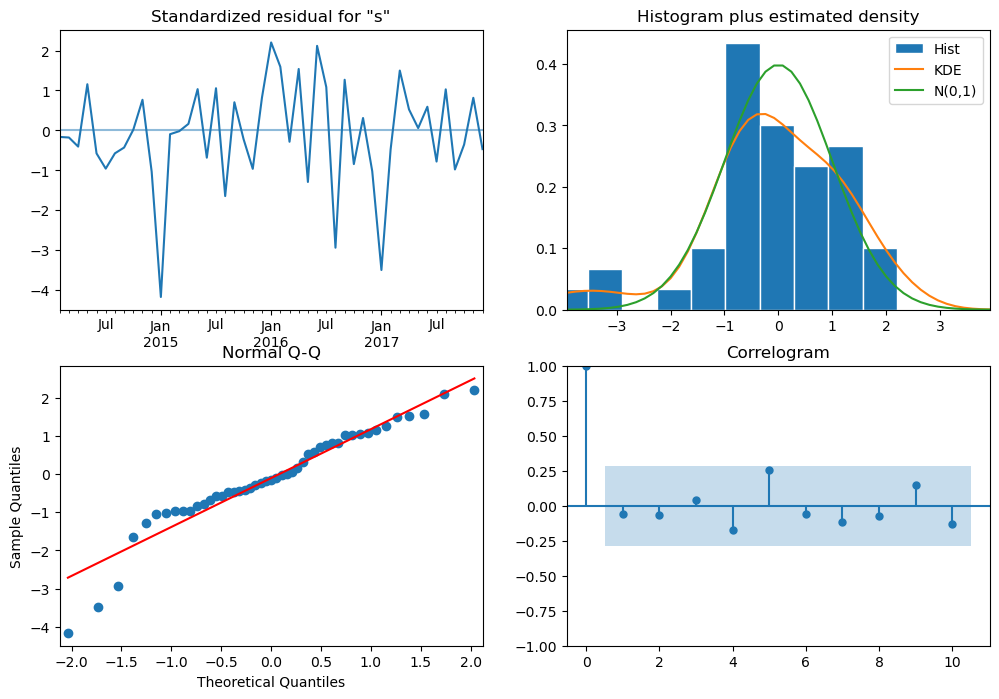

In [68]:
sar.plot_diagnostics(figsize=(12, 8));